In [44]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp
from brian2.units.fundamentalunits import get_unit_for_display
from scipy import optimize as op
%matplotlib notebook

from importlib import reload
reload(dp);


In [45]:
nts = ['pr_noci']
ats =[]
Ns = dp.get_Ns()
intrinsics_df = dp.intrinsics_table_w_units()
ndf = dp.interneuronal_connectivity_tables()
adf = dp.afferent_connectivity_tables()

In [60]:
Ns['pr_noci'] = 1

In [61]:
class adex_group(NeuronGroup):
    def __init__(self, name, N = 1):
        model = '''dv/dt = (Delta_T*g_l*exp((-V_th + v)/Delta_T)
                 + g_e*(E_e - v) + g_i*(E_i - v) + g_l*(E_l - v) - u + I_ex(t, i))/C_m : volt (unless refractory)
                 dg_e/dt = -g_e/tau_e : siemens
                 dg_i/dt = -g_i/tau_i : siemens
                 du/dt = (alpha*(-E_l + v) - u)/tau_u : amp
                 g_l : siemens (constant)'''
        reset_eq = '''v = V_r
        u += b'''
        threshold_eq = 'v > V_th'
        refractory_eq = 'tau_r'
        super().__init__(
            N = N, model = model,
            reset = reset_eq,
            threshold = threshold_eq,
            refractory = refractory_eq,
            method = 'euler',
            name = name)
        
        
    def reset_variables(self):
        self.g_i = '0 * nS'
        self.g_e = '0 * nS'
        self.v = self.namespace['E_l']  
        self.u = '0 * pA'
    
    def initialize_I_ex_array(self):
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.namespace['I_ex_mu']
        I_ex_sigma = self.namespace['I_ex_sigma']
        I_ex_template = (I_ex_mu + I_ex_sigma * randn(self.N))
        I_ex_array = np.tile(I_ex_template, (tb.shape[0],1))
        self.namespace['I_ex_array'] = np.array(I_ex_array)
        self.namespace['I_ex'] = TimedArray(I_ex_array,sim_dt)
    
    def set_I_ex_from_array(self,I_ex_array):
        assert type(I_ex_array) is numpy.ndarray
        tb = np.arange(0,len(I_ex_array))*sim_dt
        self.namespace['I_ex_array'] = I_ex_array
        self.namespace['I_ex'] = TimedArray(I_ex_array * pA,sim_dt)
    
    def add_I_ex_step(self, start, stop, amplitude, indices = None):
        tb = np.arange(0,duration,sim_dt)
        I_ex_template = np.zeros((len(tb),self.N))
        
        if not indices:
            indices = range(self.N)        
        I_ex_template = self.namespace['I_ex_array'] * pA
        
        for t_ind,t in enumerate(tb):
            if (t >= start) & (t < stop):
                for i in indices:
                    I_ex_template[t_ind,i] = amplitude
        self.namespace['I_ex_array'] = np.array(I_ex_template)
        self.namespace['I_ex'] = TimedArray(I_ex_template,sim_dt)

    def set_cell_type(self, cell_type):
        params = dp.get_neuron_params(cell_type)
        
        self.outputs = params['outputs']
        
        for key, value in params['intrinsics'].items():
            self.namespace[key] = value
            
        # constant parameters that vary between neurons in this group
        g_l_mu = params['intrinsics']['g_l_mu']
        g_l_sigma = params['intrinsics']['g_l_sigma']
        self.g_l = (g_l_mu + g_l_sigma * randn(self.N))
        self.reset_variables()
        
    def set_intrinsics(self,intrinsics):
        
        for key, value in intrinsics.items():
            self.namespace[key] = value
            
        # constant parameters that vary between neurons in this group
        g_l_mu = intrinsics['g_l_mu']
        g_l_sigma = intrinsics['g_l_sigma']
        self.g_l = (g_l_mu + g_l_sigma * randn(self.N))
        self.reset_variables()
        
    def set_intrinsics_from_dfs(self,intrinsics_df):
        params = intrinsics_df.columns
        intrinsics = {}
        for param in params:
            tempstr = str(intrinsics_df.loc[self.name,param]) + ' * ' + intrinsics_df.loc['units',param]
            intrinsics[param] = eval(tempstr)
        
        for key, value in intrinsics.items():
            self.namespace[key] = value
            
        # constant parameters that vary between neurons in this group
        g_l_mu = intrinsics['g_l_mu']
        g_l_sigma = intrinsics['g_l_sigma']
        self.g_l = (g_l_mu + g_l_sigma * randn(self.N))
        self.reset_variables()
    
    def set_outputs_from_dfs(self,output_dfs):
        temp_dict ={}
        outputs = {}
        for param_name,output_df in output_dfs.items():
            temp_dict[param_name] = output_df.loc[self.name,:]
        
        targets = list(temp_dict['p'][temp_dict['p']>0].index)
        for post in targets:
            outputs[post] = {}
            for param_name,param in temp_dict.items():
                if param_name in ['w_mu','w_sigma']:
                    outputs[post][param_name] = param[post] * siemens
                else:
                    outputs[post][param_name] = param[post]
        self.namespace['outputs'] = outputs        
        
class afferent_group(SpikeGeneratorGroup):
    def __init__(self, name, N = 1):
        super().__init__(N = N,indices = [0], times = [9999*second],name = name)
            
def connect_all_ngs_from_dfs(ngs,ng_output_dfs):
    s = {}
    for pre_name,pre in ngs.items():
        for post_name,post in ngs.items():
            if ng_output_dfs['p'].loc[pre_name,post_name]>0:
                temp_dict ={}
                for param_name,output_df in ng_output_dfs.items():
                    if param_name in ['w_mu','w_sigma']:
                        temp_dict[param_name] = output_df.loc[pre_name,post_name] * siemens
                    else:
                        temp_dict[param_name] = output_df.loc[pre_name,post_name]
                
                temp_s = connect_neuron_groups(pre, post,
                    **temp_dict)
                s[temp_s.name]= temp_s  
    return s

def connect_all_ags_from_dfs(ngs,ags,ag_output_dfs):
    s = {}
    for pre_name,pre in ags.items():
        for post_name,post in ngs.items():
            if ag_output_dfs['p'].loc[pre_name,post_name]>0:
                temp_dict ={}
                for param_name,output_df in ag_output_dfs.items():
                    if param_name in ['w_mu','w_sigma']:
                        temp_dict[param_name] = output_df.loc[pre_name,post_name] * siemens
                    else:
                        temp_dict[param_name] = output_df.loc[pre_name,post_name]
                
                temp_s = connect_neuron_groups(pre, post,
                    **temp_dict)
                s[temp_s.name]= temp_s
    return s
    


def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    name = pre_group.name + '_to_'+post_group.name
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation,name = name)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

def output_dfs_2_dict(output_dfs,nts):   
    outputs = {}
    for pre in nts:
        for post in nts:
            outputs[pre][post]={}
        
    for param_name, output_df in output_dfs.items():
        for pre in nts:
            for post in output_df.columns:
                outputs[pre][post]={}
                outputs[pre][post][param_name] = output_df.loc[pre,post]
    return outputs

def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,duration,sim_dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,duration,sim_dt)
        psth = np.ones(time_bins.shape)*sim_dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *sim_dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

fsiemens = siemens * 1e-15
fS = fsiemens
asiemens = siemens * 1e-18
aS = asiemens

In [76]:
def initialize_inputs(ags, ngs, num_trials, trial_durations = None):
    if not trial_durations:
        trial_durations = [duration] * num_trials
    
    inputs = {}
    for trial in range(num_trials):
        inputs[trial] = {}
        for at,ag in ags.items():
            inputs[trial][at] = {}
            inputs[trial][at]['spike_times'] = ag._spike_time
            inputs[trial][at]['indices'] = ag._neuron_index
        for nt,ng in ngs.items():
            inputs[trial][nt] = {}
            inputs[trial][nt]['I_ex'] = ng.namespace['I_ex_array'].copy()
        inputs[trial]['trial_duration'] = trial_durations[trial]
    return inputs

def concat_inputs(inputs):
    I_ex_arrays ={}
    for nts in sim_objects['neuron_groups'].keys():
        I_ex_arrays[nt]=[]
        for trial,this_input in inputs.items():
            I_ex_arrays[nt].append(this_input[nt]['I_ex'])
        I_ex_arrays[nt] = np.concatenate(I_ex_arrays[nt])
    #need to test    
    ag_inputs_full_trial = {}
    for at in sim_objects['afferent_groups'].keys():
        ag_inputs_full_trial[at] = {}
        t_start = 0 * second
        ag_inputs_full_trial[at]['spike_times'] =[]
        ag_inputs_full_trial[at]['indices'] = []
        for trial,this_input in inputs.items():
            ag_inputs_full_trial[at]['spike_times'].append(this_input[at]['spike_times'] + t_start)
            ag_inputs_full_trial[at]['indices'].append(this_input[at]['indices'])
            t_start += this_input['trial_duration']
        ag_inputs_full_trial[at]['spike_times'] =np.concatenate(ag_inputs_full_trial[at]['spike_times'])
        ag_inputs_full_trial[at]['indices'] =np.concatenate(ag_inputs_full_trial[at]['indices'])
    return I_ex_arrays,ag_inputs_full_trial

def make_active_inds_binary(frac_active, N):
    num_active = np.round(frac_active * N).astype(int)
    active_inds = np.random.choice(np.array(range(N)),size = num_active)
    active_inds_binary = np.zeros((N))
    for ind in active_inds:
        active_inds_binary[ind] = 1
    return active_inds, active_inds_binary

# should make outputs and cost function together

def get_trialwise_spikes(inputs, sim_objects):
    observed_spikes = {}
    trial_start = 0 * ms
    for trial, this_input in inputs.items():
        observed_spikes[trial] = {}
        trial_duration = this_input['trial_duration']
        trial_end = trial_start + trial_duration
        for nt in sim_objects['spike_mons'].keys():
            N = sim_objects['neuron_groups'][nt].N
            observed_spikes[trial][nt]={}
            observed_spikes[trial][nt]['counts'] = []
            observed_spikes[trial][nt]['rates'] = []
            spike_trains = sim_objects['spike_mons'][nt].spike_trains()
            for neuron,spike_times in spike_trains.items():
                current_trial_spike_times = spike_times[(spike_times>=trial_start) & (spike_times<trial_end)]
                current_trial_spike_count = len(current_trial_spike_times)
                observed_spikes[trial][nt]['counts'].append(current_trial_spike_count)
                observed_spikes[trial][nt]['rates'].append(current_trial_spike_count/trial_duration*second)
                
            observed_spikes[trial][nt]['mean_count'] = mean(observed_spikes[trial][nt]['counts'])
            observed_spikes[trial][nt]['mean_rate'] = mean(observed_spikes[trial][nt]['rates'])
        trial_start += trial_duration
    return observed_spikes

def mean_spike_count_cost_func(target_outputs, observed_spikes):
    differences = []
    for trial, this_trial_output in target_outputs.items():
        for nt, target_counts in this_trial_output.items():
            differences.append((target_counts - observed_spikes[trial][nt]['mean_count'])**2)
    cost = sum(differences)**0.5
    return cost

def initialize_target_outputs(inputs):
    target_outputs = {}
    for trial,this_input in inputs.items():
        target_outputs[trial] = {}
    return target_outputs   

def add_target_mean_rate(target_outputs, rate_vec, nt):
    assert len(rate_vec) == len(target_outputs)
    for trial,rate in enumerate(rate_vec):
        target_outputs[trial][nt] = rate
    return target_outputs



def run_sim(sim_objects, inputs, target_outputs, cost_func):
    # inputs: dictionary with fields 'ag_rates','ng_I_ex', 'num_trials'
    # sim_objects: dictionary with fields 'network','neuron_group_list','afferent_group_list','synapse_list'
            
    #resetting
    I_ex_full,ag_inputs_full = concat_inputs(inputs)
    for nt,ng in sim_objects['neuron_groups'].items():
        ng.set_I_ex_from_array(I_ex_full[nt])
    for at,ag in sim_objects['afferent_groups'].items():
        ag.set_spikes(indices = ag_inputs_full[at]['indices'], times = ag_inputs_full[at]['spike_times']) 
        
    for trial in range(num_trials):
        duration = inputs[trial]['trial_duration']
        for nt,ng in ngs.items():
            ng.reset_variables()
#         for at,ag in ags.items():
#             spike_times = inputs[trial][at]['spike_times']
#             indices = inputs[trial][at]['indices']
#             ag.set_spikes(indices = indices, times = spike_times + net.t)
        
        net.run(duration)
    observed_spikes = get_trialwise_spikes(inputs, sim_objects)
    cost = cost_func(target_outputs,observed_spikes)
    return cost, observed_spikes

def fit_network(x, update_funcs, sim_objects,  inputs, target_outputs, cost_func):
    # inputs: dictionary with fields 'ag_rates','ng_I_ex'
    # sim_objects: dictionary with fields 'network','ngs','ags','s'
    # target_outputs: dictionary with fields corresponding to neuron_groups
    # cost_func: of form cost = f(spks,target_outputs)
    # free_params: dict with fields ['intrinsics','synaptic']
    
    sim_objects['network'].restore()
    beta = {}
    for param,this_x in zip(update_funcs.keys(),x):
        beta[param] = this_x
        update_funcs[param](this_x)
    cost, observed_spikes = run_sim(sim_objects, inputs, target_outputs, cost_func)
    
    beta_.append(beta)
    observed_spikes_.append(observed_spikes)
    cost_.append(cost)
    print(cost)
    return cost

def initialize_bounds(update_funcs):
    # doesn't work for synapses yet
    # maybe should pull from param dfs
    uf_keys = list(update_funcs.keys())
    init_vals = {}
    for uf_key in uf_keys:
        if type(uf_key) is tuple:
            init_vals[uf_key] = sim_objects['neuron_groups'][uf_key[0]].namespace[uf_key[1]]
        elif type(uf_key) is str:
            init_vals[uf_key] = np.mean(sim_objects['synapses'][uf_key].w)
    return init_vals

In [77]:
def wrap_update_w(syn):
    def update_w(w_mu):
        w_sigma = 0.1
        syn.w = (w_mu + w_sigma * randn(syn.w.shape[0]))* nS
        syn.w['w < 0 * nS'] = 0 * nS
    new_func = update_w
    return new_func

def gen_s_w_update_funcs(s,s_names = None):
    s_w_update_funcs = {}
    if not s_names:
        s_names = list(s.keys())
    for s_name in s_names:
        s_w_update_funcs[s_name] = wrap_update_w(s[s_name])
    return s_w_update_funcs

def wrap_update_intrinsics(ng, var_name):
    if var_name is 'g_l_mu':
        def update_g_l(g_l_mu):
            g_l_sigma = 0.1
            ng.g_l = (g_l_mu + g_l_sigma * randn(ng.g_l.shape[0])) * nS
        new_func = update_g_l
    else:
        def update_intrinsics(x):
            this_unit = get_unit_for_display(ng.namespace[var_name].dim)
            temp_str = str(x) + '*' + this_unit
            ng.namespace[var_name] = eval(temp_str)
        new_func = update_intrinsics
    return new_func

def gen_intrinsics_update_funcs(ngs,ng_var_pairs_list):
    intrinsics_update_funcs = {}
    for ng_name,var_name in ng_var_pairs_list:
        intrinsics_update_funcs[(ng_name,var_name)] = wrap_update_intrinsics(ngs[ng_name],var_name)
    return intrinsics_update_funcs

In [81]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1200*ms  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt

In [82]:
# initialize network
ngs = {}
spike_mons = {}
poprates = {}
synapses = []
states = {}
for nt in nts:
    ng = adex_group(name = nt, N = Ns[nt])
    ng.set_intrinsics_from_dfs(intrinsics_df)
    ng.initialize_I_ex_array()
    ngs[nt] = ng
    spike_mons[nt]= SpikeMonitor(ngs[nt], record=True)  
    poprates[nt] = PopulationRateMonitor(ngs[nt])
    states[nt]= StateMonitor(ngs[nt],variables = 'v', record=False) 
    
ags = {}
for at in ats:
    ags[at] = afferent_group(name = at, N = Ns[at])   
    
s = connect_all_ngs_from_dfs(ngs,ndf)
s.update(connect_all_ags_from_dfs(ngs,ags,adf))

# net = Network(ngs,ags,s,spks,states,poprates)
net = Network(ngs,ags,s,spike_mons,states)
net.store()


In [83]:
net.restore()

In [29]:
ng.set_I_ex_from_array(I_ex_arrays[nt])

In [31]:
net.run(20*second)

In [84]:
#output = tensor: rates x psth x num_trials
num_trials = 16
inputs = initialize_inputs(ags,ngs,num_trials)

currents = np.linspace(0,150,16)
# currents[-1]=400

# nt = 'pr_noci'
for ii, current in enumerate(currents):
    inputs[ii]['pr_noci']['I_ex'][1000:11000,:] = current.copy()

# rates_of_active = np.ones((num_trials)) * 2.
# frac_active = np.linspace(0,1,num_trials)
# psth_kernel,_ = gaussian_psth(mu = 5 * ms, sigma = 1 * ms)

# at = 'pep2'
# for trial,frac in enumerate(frac_active):
#     _, active_binary = make_active_inds_binary(frac, ags[at].N)
#     rate_vec = np.ones((ags[at].N))* rates_of_active[trial] * active_binary
#     spike_times,indices = generate_population_spikes(psth_kernel,rate_vec)
#     inputs[trial][at]['spike_times'] = spike_times
#     inputs[trial][at]['indices'] = indices

# rates_of_active = np.ones((num_trials)) * 10.
# frac_active = np.ones((num_trials))
# at = 'corticospinal'
# for trial,frac in enumerate(frac_active):
#     _, active_binary = make_active_inds_binary(frac, ags[at].N)
#     rate_vec = np.ones((ags[at].N))* rates_of_active[trial] * active_binary
#     spike_times,indices = generate_population_spikes(psth_kernel,rate_vec)
#     inputs[trial][at]['spike_times'] = spike_times
#     inputs[trial][at]['indices'] = indices

In [85]:
target_outputs = initialize_target_outputs(inputs)

def logistic_func(x,top,hill,ec50):
    return top/(1 + exp(-hill* (x - ec50)))

rate_vec = logistic_func(currents,40,0.1,50)
target_outputs = add_target_mean_rate(target_outputs, rate_vec, 'pr_noci')


In [86]:
update_funcs = {}
ng_vpl= [('pr_noci','g_l_mu'),('pr_noci','b'),('pr_noci','tau_u'),('pr_noci','alpha'),('pr_noci','V_r')]
update_funcs.update(gen_intrinsics_update_funcs(ngs,ng_vpl))
update_funcs

{('pr_noci',
  'g_l_mu'): <function __main__.wrap_update_intrinsics.<locals>.update_g_l(g_l_mu)>,
 ('pr_noci',
  'b'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'tau_u'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'alpha'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'V_r'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>}

In [87]:
sim_objects ={}
sim_objects['network'] = net
sim_objects['neuron_groups'] = ngs
sim_objects['afferent_groups'] = ags
sim_objects['synapses'] = s
sim_objects['spike_mons'] = spike_mons

In [88]:
ngs['pr_noci'].namespace

{'E_l': -60. * mvolt,
 'E_e': 0. * volt,
 'E_i': -70. * mvolt,
 'C_m': 40. * pfarad,
 'V_th': -40. * mvolt,
 'V_r': -60. * mvolt,
 'tau_e': 2. * msecond,
 'tau_i': 5. * msecond,
 'tau_r': 1. * msecond,
 'g_l_mu': 2. * nsiemens,
 'g_l_sigma': 250. * psiemens,
 'I_ex_mu': 0. * amp,
 'I_ex_sigma': 0. * amp,
 'b': 5. * pamp,
 'alpha': 200. * psiemens,
 'Delta_T': 1. * mvolt,
 'tau_u': 150. * msecond,
 'I_ex_array': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'I_ex': <brian2.input.timedarray.TimedArray at 0x1a4f7e93dd8>}

In [89]:
update_funcs

{('pr_noci',
  'g_l_mu'): <function __main__.wrap_update_intrinsics.<locals>.update_g_l(g_l_mu)>,
 ('pr_noci',
  'b'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'tau_u'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'alpha'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>,
 ('pr_noci',
  'V_r'): <function __main__.wrap_update_intrinsics.<locals>.update_intrinsics(x)>}

In [ ]:
global cost_, observed_spikes_, beta_
cost_ = []
observed_spikes_ = []
beta_ = []

bounds = [(0.1,2.5),(-10e-12,10e-12),(1e-3,200e-3),(-1e-9,1e-9),(-70e-3,-50e-3)]
res = op.differential_evolution(func = fit_network,bounds = bounds,
    args = [update_funcs,sim_objects,inputs,target_outputs,mean_spike_count_cost_func],polish = False,
    maxiter = 10)

169.59018165952776
461.01602111245535
328.2638106444904
84.63514864351413
83.68066172757817
43.38716822678772
36.113687549862554
183.53393370382344
170.52254343857027
100.20267251061853
157.5043908234635
374.8676844210518
371.2040771624032
1056.1159089020753
133.30528201754348
77.93090186772238
82.06578902762185
215.22223438940307
33.981974584129006
49.39631803221955
418.13499705699263
466.94898437607327
879.8403866728536
58.12420916558275
325.1759148909889
463.8697861804082
202.0686791924863
70.27456852636614
305.79516676865836
308.8774563438817
189.59843823288176
379.89113198001996
451.02704737854907
482.6226233007024
284.4468396957677
186.86610551219815
418.2662370342024
132.36670411612127
96.08264538723893
1273.7531725011365
488.18143275909483
109.96927652660877
904.9650912512064
223.36921035530642
171.8029310059173
930.3720672196309
461.9516099537917
383.13040981118195
101.90887777884944
101.52748416057621
335.8442657382569
322.33093496203645
108.22987057688556
137.3491189883034
2

<IPython.core.display.Javascript object>


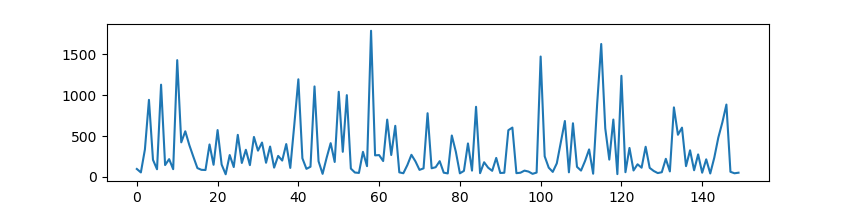

In [92]:
plt.plot(cost_)

In [324]:
ngs['pr_noci'].namespace['I_ex'](1000*ms,0)

0.4 * zamp

In [318]:
inputs[15]['pr_noci']['I_ex']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
ng.set_I_ex_from_array(inputs[trial][nt]['I_ex'])

In [336]:
net.restore()
# ngs['pr_noci'].add_I_ex_step(100*ms,1100*ms,200*pA)
ng.set_I_ex_from_array(inputs[15]['pr_noci']['I_ex'])
net.run(duration)

In [337]:
# plt.imshow(ng.namespace['I_ex_array'].T,aspect = 'auto')
plt.imshow(inputs[15]['pr_noci']['I_ex'].T,aspect = 'auto')

In [323]:
states['pr_noci'].v[0,2000]

-60. * mvolt

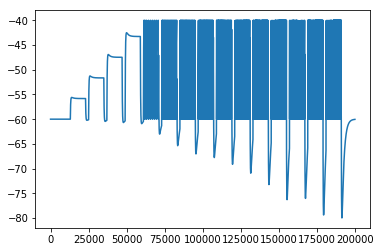

In [32]:
plt.plot(states['pr_noci'].v[0,:]/mV)

In [16]:
fit_network(x, update_funcs, sim_objects,  inputs, target_outputs, cost_func = mean_spike_count_cost_func)

NameError: name 'x' is not defined

In [100]:
mean(ngs['pr_noci'].namespace['I_ex_array'])

5.83333333333333e-11

In [41]:
spike_mon.spike_trains()

{0: array([5.9, 8.1]) * msecond,
 1: array([5.1, 6.5, 8.6]) * msecond,
 2: array([4.9, 7. ]) * msecond,
 3: array([5.6, 8. ]) * msecond,
 4: array([5.8, 8. ]) * msecond,
 5: array([5.5, 7.3]) * msecond,
 6: array([5.8]) * msecond,
 7: array([5.3, 7.7]) * msecond,
 8: array([5.3, 7.4]) * msecond,
 9: array([5.2, 6.6, 8.6]) * msecond,
 10: array([5.2, 7.3]) * msecond,
 11: array([5.5, 7.8]) * msecond,
 12: array([5.9, 8.4]) * msecond,
 13: array([4.9, 6.5, 9. ]) * msecond,
 14: array([7.5]) * msecond,
 15: array([5.8, 8.1]) * msecond,
 16: array([7.9]) * msecond,
 17: array([6.]) * msecond,
 18: array([4.5, 5.9, 7.4, 9.8]) * msecond,
 19: array([6.]) * msecond}

In [ ]:
net.restore()
ags['pep2'].set_spikes(indices = inputs[7]['pep2']['indices'], times = inputs[7]['pep2']['spike_times'])
net.run(duration)

<IPython.core.display.Javascript object>


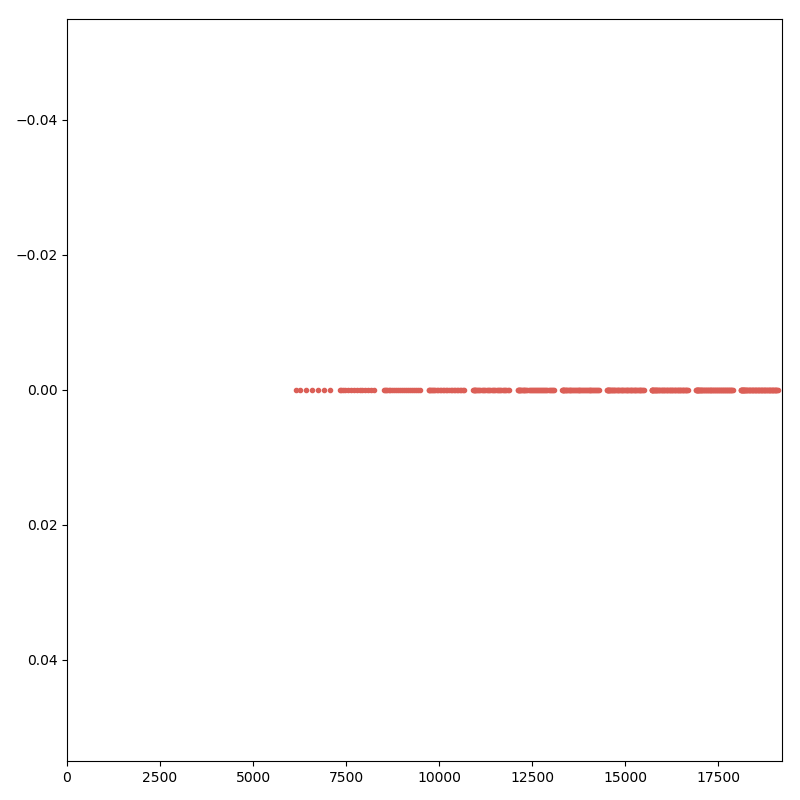

(0, 19199.999999999996)

In [93]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [25]:
update_funcs = {}
# ng_vpl= [('pr_WDR','E_l'),('e_WDR','E_l')]
# update_funcs.update(gen_intrinsics_update_funcs(ngs,ng_vpl))
update_funcs.update(gen_s_w_update_funcs(s))

In [17]:
update_funcs 

{'pep2_to_pr_noci': <function __main__.wrap_update_w.<locals>.update_w(w_mu)>,
 'pep2_to_i_WDR': <function __main__.wrap_update_w.<locals>.update_w(w_mu)>,
 'i_WDR_to_pr_noci': <function __main__.wrap_update_w.<locals>.update_w(w_mu)>,
 'i_WDR_to_pr_WDR': <function __main__.wrap_update_w.<locals>.update_w(w_mu)>,
 'pep2_to_pr_WDR': <function __main__.wrap_update_w.<locals>.update_w(w_mu)>}

In [17]:
def calc_pop_rates_per_trial(spks,num_trials,duration):
    ng_counts = {}
    ng_counts_avg ={}
    for nt,spikemon in spks.items():
        trial_start = 0 * ms
        spike_trains = spikemon.spike_trains()
        ng_counts[nt] = np.zeros((len(spike_trains.keys()),num_trials))
        ng_counts_avg[nt] = np.zeros((num_trials))
        for trial in range(num_trials):
            trial_end = trial_start + duration
            for n,times in spike_trains.items():
                this_count = sum((times>=trial_start) & (times<trial_end))
                ng_counts[nt][n,trial]= this_count
            ng_counts_avg[nt][trial] = ng_counts[nt][:,trial].mean()
            trial_start += duration
    return ng_counts,ng_counts_avg

def cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR']):
    cost = 0.
    for nt in nts:
        cost += sum((target_ng_rates[nt] - measured_ng_rates[nt])**2) **0.5
    return cost

In [ ]:
st = spike_mons['i_WDR'].spike_trains()[0]
trial_start = 20*ms
trial_end = 50 * ms
st[(st>=trial_start) & (st<trial_end)]

In [ ]:
trialwise_spikes = get_trialwise_spikes(inputs, sim_objects)
trialwise_spikes[0]['i_WDR']

In [30]:
target_outputs

{0: {'pr_noci': 0.0},
 1: {'pr_noci': 1.4285714285714286},
 2: {'pr_noci': 2.857142857142857},
 3: {'pr_noci': 4.285714285714286},
 4: {'pr_noci': 5.714285714285714},
 5: {'pr_noci': 7.142857142857143},
 6: {'pr_noci': 8.571428571428571},
 7: {'pr_noci': 10.0}}

In [ ]:
inputs[0]['pr_noci']

In [ ]:
def adjust_params_and_rerun(net, ngs, ags, s, beta):
    net.restore()
    
    for name, w_mu in beta.items():
        for syn in s:
            if syn.name == name:
                syn.w = (w_mu + 0.000001 * randn(syn.w.shape[0]))* nS
                syn.w['w < 0 * nS'] = 0 * nS
                
    #resetting
    for trial in range(num_trials):
        for nt,ng in ngs.items():
            ng.reset_variables()
        for at,ag in ags.items():
            this_rate = ag_rates[at][trial]
            psth, time_bins = uniform_psth()
            rates = np.ones((ag.N)) * this_rate
            spikes,ind = generate_population_spikes(psth,rates)
            ag.set_spikes(indices = ind, times = spikes + net.t)
        net.run(duration)


    ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
    measured_ng_rates = {}
    for nt,counts_avg in ng_counts_avg.items():
        measured_ng_rates[nt] = counts_avg / duration*second    
    return measured_ng_rates

def run_network_change_syn(x, net, ngs, ags, s, free_s_params, target_ng_rates):
    beta = {}
    for free_s_param,this_x in zip(free_s_params,x):
        beta[free_s_param] = this_x
    measured_ng_rates = adjust_params_and_rerun(net, ngs, ags, s, beta)
    cost = cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR'])
    
#     beta_.append(x)
#     rates_.append(rates)
#     cost_.append(cost)
    print(x, cost)

    return cost

In [ ]:
bounds = [(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8)]
bounds = [(0.5,8)] * len(free_s_params)
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, ngs,ags,s,free_s_params,target_ng_rates],polish = False,
                                maxiter = 1)

In [ ]:
ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
measured_ng_rates = {}
for nt,counts_avg in ng_counts_avg.items():
    measured_ng_rates[nt] = counts_avg / duration*second    

In [ ]:
cost_func(target_ng_rates,measured_ng_rates)

In [ ]:
ng_counts_avg['pr_noci']

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spks.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:

f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
for z,(nt,counts) in enumerate(ng_counts.items()):
    ax.plot(np.arange(num_trials),counts.mean(axis=0),'-o',color = cmap[z])
        

In [ ]:
counts.mean(axis = 0)

In [ ]:
net.t/duration

In [ ]:
outrate = poprates['pr_noci'].smooth_rate(width = 100 *ms)

In [ ]:
spks['e_grp'].t

In [ ]:
#restoring
hold_spikes = {}
for nt in ngs.keys():
    hold_spikes[nt] = {'ind':[],'spikes':[]}
for trial in range(num_trials):
    net.restore()
    for at,ag in ags.items():
        this_rate = ag_rates[at][trial]
        psth, time_bins = uniform_psth()
        rates = np.ones((ag.N)) * this_rate
        spikes,ind = generate_population_spikes(psth,rates)
        ag.set_spikes(indices = ind, times = spikes)
    net.run(duration, profile = True, report = 'text')
    
    for nt in ngs.keys():
        hold_spikes[nt]['ind'].append(ind.copy())
        hold_spikes[nt]['spikes'].append(spikes.copy())

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [ ]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

In [ ]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [ ]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [ ]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [ ]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

In [ ]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [ ]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


In [ ]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

In [ ]:
bins = np.arange(0,duration/ms,1)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
bins = np.arange(0,duration/ms,1)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
spikes.items()

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)